In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

/home/swjeong/swjeong/swjenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
manualSeed = 555

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  555


In [3]:
path = "./input"
batch_size = 128
image_size = 64
nz = 100
num_epochs = 3
lr = 0.001
beta1 = 0.5

In [4]:
dataset = torchvision.datasets.ImageFolder(path,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

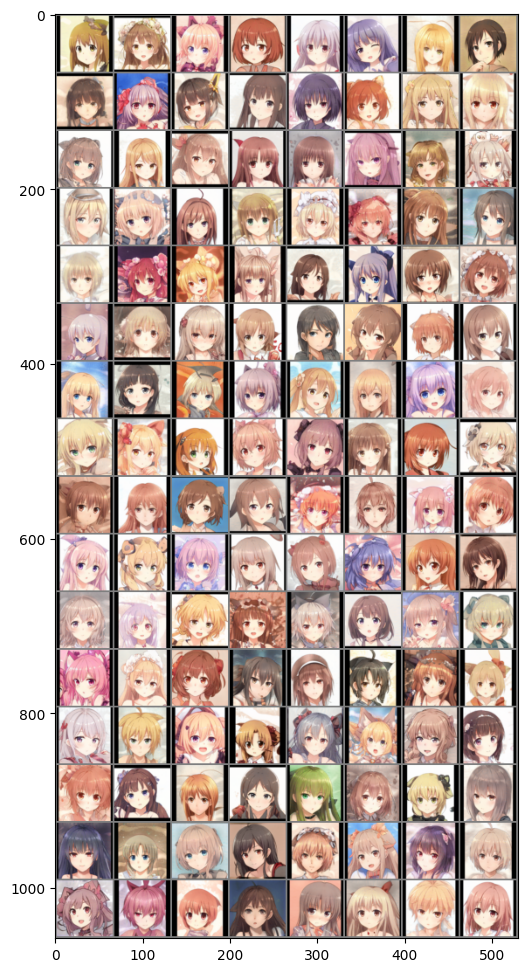

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)
plt.figure(figsize=(12,12))
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def plot_results(G_losses, D_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [8]:
from model import Discriminator, ModelClass

netD = Discriminator().to(device)
if device.type == 'cuda':
    netD = nn.DataParallel(netD)
netD.apply(weights_init)

netG = ModelClass().to(device)
if device.type == 'cuda':
    netG = nn.DataParallel(netG)
netG.apply(weights_init)

DataParallel(
  (module): ModelClass(
    (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (btnt1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relut1): ReLU(inplace=True)
    (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btnt2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relut2): ReLU(inplace=True)
    (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btnt3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relut3): ReLU(inplace=True)
    (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btnt4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relut4): ReLU(inplace=True)
    (convt5): ConvTranspose2d(64, 3, kernel_size=(4, 4), str

In [9]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: 
     
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

/home/swjeong/swjeong/swjenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/swjeong/swjeong/swjenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


[0/3][0/201]	Loss_D: 1.6832	Loss_G: 20.5411	D(x): 0.5083	D(G(z)): 0.5346 / 0.0000
[0/3][50/201]	Loss_D: 1.8215	Loss_G: 2.3155	D(x): 0.4445	D(G(z)): 0.2039 / 0.1916
[0/3][100/201]	Loss_D: 0.7474	Loss_G: 8.6402	D(x): 0.9611	D(G(z)): 0.4392 / 0.0009
[0/3][150/201]	Loss_D: 1.0637	Loss_G: 2.2028	D(x): 0.7059	D(G(z)): 0.3170 / 0.1993
[0/3][200/201]	Loss_D: 1.4837	Loss_G: 4.5801	D(x): 0.6618	D(G(z)): 0.5251 / 0.0189
[1/3][0/201]	Loss_D: 1.0755	Loss_G: 2.1508	D(x): 0.4836	D(G(z)): 0.1111 / 0.2109
[1/3][50/201]	Loss_D: 0.8514	Loss_G: 4.8895	D(x): 0.8554	D(G(z)): 0.4379 / 0.0126
[1/3][100/201]	Loss_D: 0.9597	Loss_G: 4.7050	D(x): 0.7186	D(G(z)): 0.3095 / 0.0221
[1/3][150/201]	Loss_D: 0.9041	Loss_G: 4.8463	D(x): 0.8084	D(G(z)): 0.4497 / 0.0145
[1/3][200/201]	Loss_D: 1.4724	Loss_G: 4.1792	D(x): 0.6770	D(G(z)): 0.5582 / 0.0367
[2/3][0/201]	Loss_D: 1.2998	Loss_G: 4.2238	D(x): 0.6701	D(G(z)): 0.4452 / 0.0347
[2/3][50/201]	Loss_D: 1.1235	Loss_G: 2.9817	D(x): 0.6092	D(G(z)): 0.3757 / 0.0749
[2/3][100/20

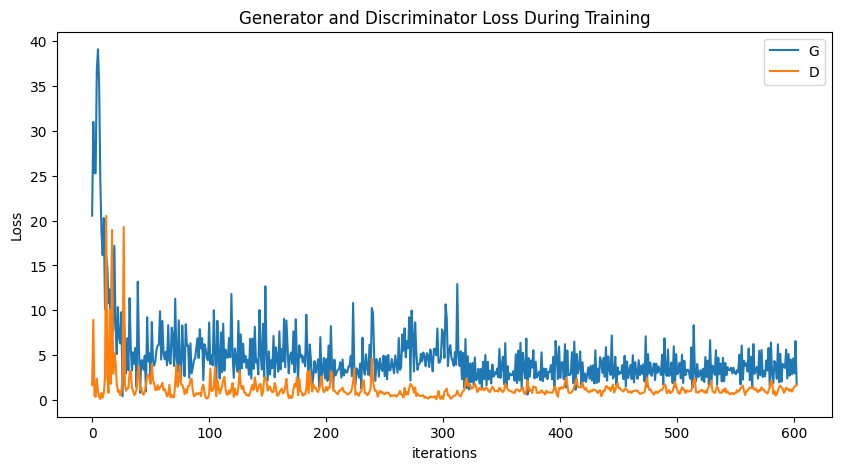

In [11]:
plot_results(G_losses, D_losses)

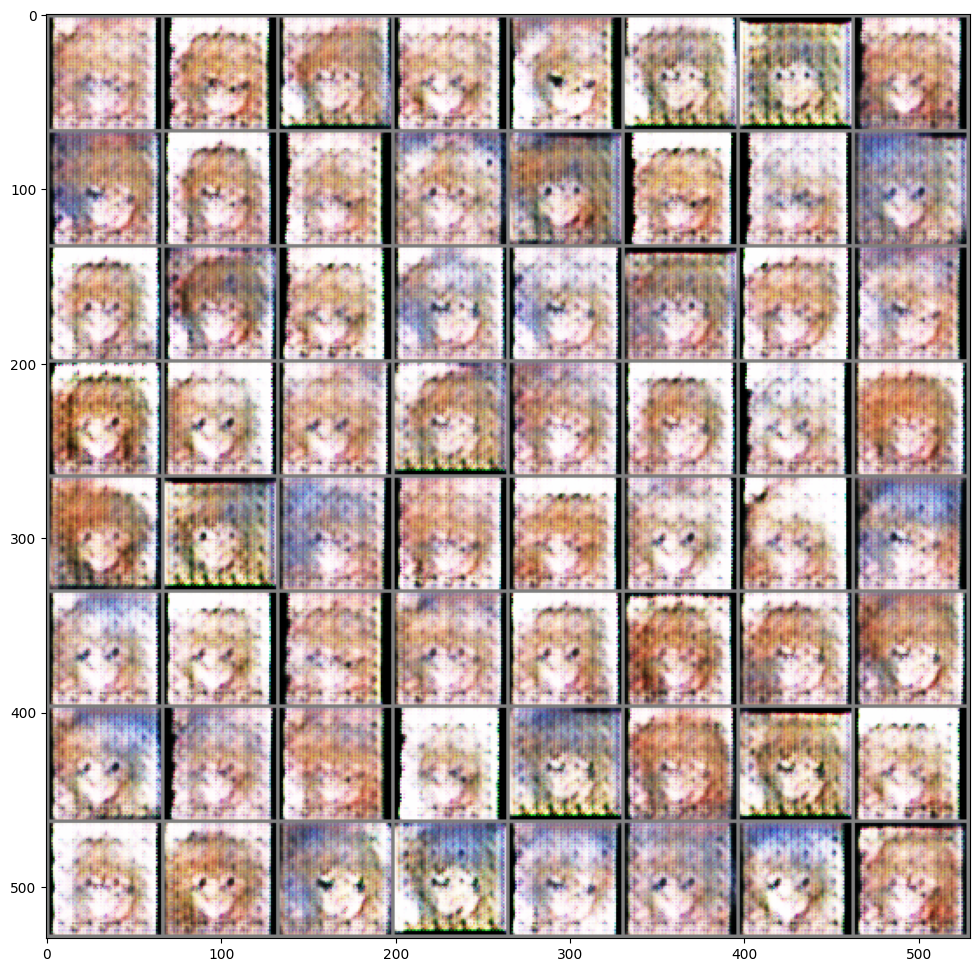

In [12]:
# 추론
with torch.no_grad():
    z = torch.randn(64, 100, 1, 1, device=device)
    fake = netG(z).detach().cpu()
    plt.figure(figsize=(12,12))
    imshow(torchvision.utils.make_grid(fake))

In [16]:
model = netG.module.to(device)
torch.save(model.state_dict(), 'torch.pt')

In [17]:
!zip -r GAN-anime.zip torch.pt model.py

updating: torch.pt (deflated 7%)
updating: model.py (deflated 80%)
